## Spatial captioning

In [1]:
import cv2
from PIL import Image

def extract_mid_frame(video_path, output_image=None):
    # Open the video file
    cap = cv2.VideoCapture(video_path)
    
    if not cap.isOpened():
        print("Error opening video file")
        return

    # Get the total number of frames
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculate the mid-frame index
    mid_frame_index = total_frames // 2

    # Set the current frame position to the mid-frame
    cap.set(cv2.CAP_PROP_POS_FRAMES, mid_frame_index)

    # Read the mid-frame
    ret, frame = cap.read()
    if ret:
        middle_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        middle_frame = Image.fromarray(middle_frame)

        if output_image is not None:
        # Save the frame as an image
            cv2.imwrite(output_image, frame)
    else:
        print("Error reading the mid frame")

    # Release the video capture object
    cap.release()

    return middle_frame

# Path to your video clip
video_clip_path = "v_BasketballDunk_g14_c06-Scene-002.mp4" # Replace with your video clip path

# Extract and save the mid-frame
middle_frame = extract_mid_frame(video_clip_path)

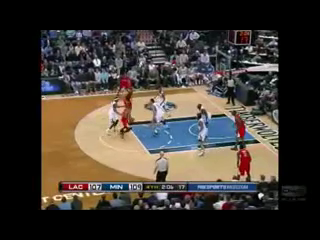

In [2]:
middle_frame

In [3]:
# Copied from https://huggingface.co/spaces/laion/CoCa/blob/main/app.py
# pip install open_clip_torch

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2" 

import open_clip
import torch

device = "cuda"
model, _, transform = open_clip.create_model_and_transforms(
    "coca_ViT-L-14",
    pretrained="mscoco_finetuned_laion2B-s13B-b90k"
)
model.to(device)

def inference_caption(image, decoding_method="Beam search", rep_penalty=1.2, top_p=0.5, min_seq_len=5, seq_len=20):
    im = transform(image).unsqueeze(0).to(device)
    generation_type = "beam_search" if decoding_method == "Beam search" else "top_p"
    
    with torch.no_grad(), torch.cuda.amp.autocast():
        generated = model.generate(
            im, 
            generation_type=generation_type,
            top_p=float(top_p), 
            min_seq_len=min_seq_len, 
            seq_len=seq_len, 
            repetition_penalty=float(rep_penalty)
        )
    return open_clip.decode(generated[0].detach()).split("<end_of_text>")[0].replace("<start_of_text>", "")

generated_caption = inference_caption(middle_frame)
print(generated_caption)

a group of men playing basketball on a court . 


## Video-level captioning

This needs its own setup. Please follow: https://github.com/yukw777/EILEV. 

After setup, run:

```bash
CUDA_VISIBLE_DEVICES=2 python samples/video_blip_generate_action_narration.py \
  --device cuda \
  /home/sayak/v_BasketballDunk_g14_c06-Scene-002.mp4 \
  "Describe the video in details."

Generated_text: the basketball player dribbles to the basket
```

## Combined captioning

In [4]:
from transformers import pipeline

pipe = pipeline(
    "text-generation",
    model="HuggingFaceH4/zephyr-7b-alpha",
    torch_dtype=torch.bfloat16,
    device_map="auto",
)

config.json:   0%|          | 0.00/628 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00008.safetensors:   0%|          | 0.00/1.89G [00:00<?, ?B/s]

model-00002-of-00008.safetensors:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

model-00003-of-00008.safetensors:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

model-00004-of-00008.safetensors:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

model-00005-of-00008.safetensors:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

model-00006-of-00008.safetensors:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

model-00007-of-00008.safetensors:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

model-00008-of-00008.safetensors:   0%|          | 0.00/816M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.43k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/168 [00:00<?, ?B/s]

In [7]:
def get_messages_for_chat():
    system_message = {
            "role": "system",
            "content": """You are part of a team of bots that combines two captions into one. Consider the first caption to come from the middle frame of a video-clip while the second caption to come from the video-clip itself.

    There are a few rules to follow:

    - You will only ever output a single caption per user request.
    - Utilize the information present in both the captions as much as possible.
    - Captions must be between 15-80 words. Extra words will be ignored.
    """,
    }

    rest_of_the_message = [
        {
            "role": "user",
            "content": "Combine the following two captions into one: 'there is a piece of wood on the floor next to a tape measure .', 'a person is using a ruler to measure a piece of wood'",
        },
        {
            "role": "assistant",
            "content": "A person is using a ruler to measure a piece of wood on the floor next to a tape measure.",
        },
        {
            "role": "user",
            "content": "Combine the following two captions into one: 'two men sitting on a rock near a river . one is holding a stick and the other is holding a pole .', 'two people are fishing in a river'",
        },
        {
            "role": "assistant",
            "content": "Two men are fishing in a river. One is holding a stick and the other is holding a pole.",
        },
        {
            "role": "user",
            "content": "Combine the following two captions into one : {user_input}",
        },
    ]
    return system_message, rest_of_the_message

In [10]:
from pprint import pprint

system_message, rest_of_the_message = get_messages_for_chat()
updated_prompt = rest_of_the_message[-1]["content"].format(
    user_input="a group of men playing basketball on a court . the basketball player dribbles to the basket."
)
rest_of_the_message[-1]["content"] = updated_prompt

final_message = [system_message]
final_message.extend(rest_of_the_message)

pprint(final_message)

[{'content': 'You are part of a team of bots that combines two captions into '
             'one. Consider the first caption to come from the middle frame of '
             'a video-clip while the second caption to come from the '
             'video-clip itself.\n'
             '\n'
             '    There are a few rules to follow:\n'
             '\n'
             '    - You will only ever output a single caption per user '
             'request.\n'
             '    - Utilize the information present in both the captions as '
             'much as possible.\n'
             '    - Captions must be between 15-80 words. Extra words will be '
             'ignored.\n'
             '    ',
  'role': 'system'},
 {'content': "Combine the following two captions into one: 'there is a piece "
             "of wood on the floor next to a tape measure .', 'a person is "
             "using a ruler to measure a piece of wood'",
  'role': 'user'},
 {'content': 'A person is using a ruler to measur

In [11]:
prompt = pipe.tokenizer.apply_chat_template(
    final_message, tokenize=False, add_generation_prompt=True
)
outputs = pipe(
    prompt,
    max_new_tokens=256,
    do_sample=True,
    temperature=0.7,
    top_k=50,
    top_p=0.95,
)

output = outputs[0]["generated_text"]
parts = output.rsplit("<|assistant|>", 1)
assistant_reply = parts[1].strip() if len(parts) > 1 else None
print(assistant_reply)

/home/sayak/.pyenv/versions/3.10.12/envs/eilev/lib/python3.10/site-packages/transformers/generation/utils.py:1518: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(


A basketball player in a group of men dribbles towards the basket on a court.
